In [2]:
"""
Here we describe experiments with a simple CNN
CIFAR 10 dataset.

Adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""

'\nHere we describe experiments with a simple CNN\nCIFAR 10 dataset.\n\nAdapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html\n'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from os.path import join as path_join, exists
from os import makedirs

In [4]:
# Setting random seed for reproducibility of the results
torch.manual_seed(0)
np.random.seed(0)

CNN_PATH = './cifar_net.pth'

IMG_TO_FILE = True  # Set this oto true if you want to store the outputs in specific files
IMG_PATH = "."

In [7]:
def plot_fig(name=None, **args):
    if IMG_TO_FILE and name is not None:
        makedirs(IMG_PATH, exist_ok=True)
        plt.savefig(path_join(IMG_PATH, name), **args)
    else:
        plt.show(**args)

In [8]:
# Download and process the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,  batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

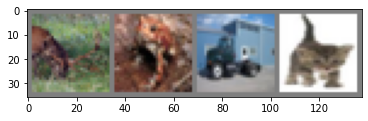

 deer  frog truck   cat


In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x


net = Net()

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
if exists(CNN_PATH):
    net.load_state_dict(torch.load(CNN_PATH))
else:

    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), CNN_PATH)

[1,  2000] loss: 2.269
[1,  4000] loss: 1.941
[1,  6000] loss: 1.697
[1,  8000] loss: 1.606
[1, 10000] loss: 1.519
[1, 12000] loss: 1.451
[2,  2000] loss: 1.402
[2,  4000] loss: 1.411
[2,  6000] loss: 1.350
[2,  8000] loss: 1.334
[2, 10000] loss: 1.306
[2, 12000] loss: 1.306
[3,  2000] loss: 1.217
[3,  4000] loss: 1.240
[3,  6000] loss: 1.210
[3,  8000] loss: 1.253
[3, 10000] loss: 1.231
[3, 12000] loss: 1.204
[4,  2000] loss: 1.141
[4,  4000] loss: 1.135
[4,  6000] loss: 1.165
[4,  8000] loss: 1.145
[4, 10000] loss: 1.161
[4, 12000] loss: 1.107
[5,  2000] loss: 1.061
[5,  4000] loss: 1.075
[5,  6000] loss: 1.080
[5,  8000] loss: 1.054
[5, 10000] loss: 1.088
[5, 12000] loss: 1.067
[6,  2000] loss: 0.985
[6,  4000] loss: 1.005
[6,  6000] loss: 1.014
[6,  8000] loss: 1.001
[6, 10000] loss: 1.050
[6, 12000] loss: 1.013
[7,  2000] loss: 0.940
[7,  4000] loss: 0.949
[7,  6000] loss: 0.972
[7,  8000] loss: 0.957
[7, 10000] loss: 1.002
[7, 12000] loss: 0.973
[8,  2000] loss: 0.898
[8,  4000] 

KeyboardInterrupt: 

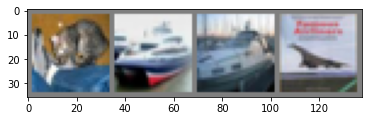

GroundTruth:    cat  ship  ship airplane


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [26]:
print(f'Accuracy of the network on the test images: {(correct / total):3.2f} %%')

Accuracy of the network on the test images: 0.62 %%


In [27]:
from nbdt.model import SoftNBDT
from nbdt.loss import SoftTreeSupLoss
from nbdt.hierarchy import generate_hierarchy


generate_hierarchy(dataset='CIFAR10', arch='vanilla', model=net, method='random')
crit_nbdt = SoftTreeSupLoss(dataset='CIFAR10', hierarchy='induced-vanilla', criterion=criterion, path_graph="./nbdt/hierarchies/CIFAR10/graph-random.json")
model = SoftNBDT(dataset='CIFAR10', model=net)

not enough values to unpack (expected 2, got 0)
No such file or directory: ./nbdt/wnids\CIFAR10.txt. Looking in C:\ProgramData\Miniconda3\envs\comp-263-essay-on-explainability\lib\site-packages
[matched] 	 Nodes: 19 	 Depth: 5 	 Max Children: 9
[pruned] 	 Nodes: 19 	 Depth: 5 	 Max Children: 9
==> Wrote tree to ./nbdt/hierarchies\CIFAR10\graph-random.json 


ValueError: invalid literal for int() with base 10: ''